In [1]:
pip install --force-reinstall agent_system/dist/mesa_restaurant_agents-0.0.1-py3-none-any.whl

In [2]:
import mesa
from mesa_restaurant_agents.model.restaurant_model import RestaurantModel

params = {"n_waiters":2, "grid_width":50, "grid_height": 50}

results = mesa.batch_run(
    RestaurantModel,
    parameters=params,
    iterations=5,
    max_steps=10,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)
print(results)

  0%|          | 0/5 [00:00<?, ?it/s]

[{'RunId': 0, 'iteration': 0, 'Step': 0, 'n_waiters': 2, 'grid_width': 50, 'grid_height': 50, 'Customer_Count': 1, 'Average_Wait_Time': np.float64(0.0), 'Average_Customer_Satisfaction': np.float64(100.0), 'Profit': np.float64(0.0), 'Customer_Info': [{'customer_nr': 4, 'waiting_time': 0, 'order_status': 1, 'satisfaction': 100}], 'Waiter_Info': [{'waiter_nr': 1, 'current_orders': {}, 'tips': 0, 'avg_rating': 0, 'served_customers': 0}, {'waiter_nr': 2, 'current_orders': {}, 'tips': 0, 'avg_rating': 0, 'served_customers': 0}]}, {'RunId': 0, 'iteration': 0, 'Step': 1, 'n_waiters': 2, 'grid_width': 50, 'grid_height': 50, 'Customer_Count': 1, 'Average_Wait_Time': np.float64(0.0), 'Average_Customer_Satisfaction': np.float64(100.0), 'Profit': np.float64(0.0), 'Customer_Info': [{'customer_nr': 4, 'waiting_time': 0.0, 'order_status': 1, 'satisfaction': 100.0}], 'Waiter_Info': [{'waiter_nr': 1, 'current_orders': {}, 'tips': 0, 'avg_rating': 0, 'served_customers': 0}, {'waiter_nr': 2, 'current_orde

c:\Users\s.neumann\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\s.neumann\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 2. 0. 2. 0. 2. 0. 2. 0. 2. 0. 2. 0. 3. 0. 2. 0. 2. 0. 2. 0. 3. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 2. 0. 2. 0. 2. 0. 2. 0. 2. 0. 2. 0. 2. 0. 2. 0. 3. 0. 2. 0. 2. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 3. 0. 2. 0. 2. 0. 2. 0. 2. 0. 2. 0. 3. 0. 2. 0. 2. 0. 2. 0. 2. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 2. 0. 2. 0. 2. 0. 3. 0. 2. 0. 3. 0. 3. 0. 2. 0. 2. 0. 2. 0. 2. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 2. 0. 3. 0. 2. 0. 2. 0. 2. 0. 2. 0. 2. 0. 2. 0. 2. 0. 2. 0. 3. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 3. 0. 2. 0. 2. 0. 2. 0. 2. 0. 3. 0. 2. 0. 3. 0. 2. 0. 2. 0. 3. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 2. 0. 2. 0. 2. 0. 3. 0. 2. 0. 2. 0. 2. 0. 2. 0. 2. 0. 3. 0.

[Text(0.5, 1.0, 'Visualization of agents in grid')]

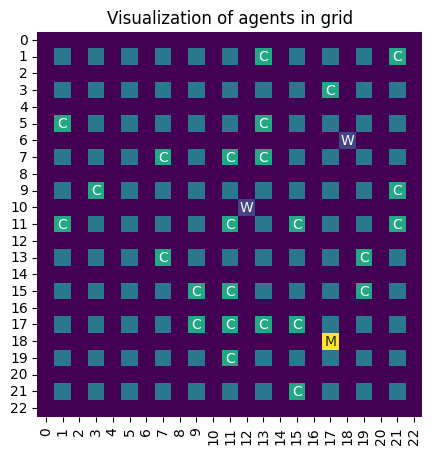

In [3]:
import seaborn as sns
import numpy as np
from mesa_restaurant_agents.agents.customer_agent import CustomerAgent
from mesa_restaurant_agents.agents.manager_agent import ManagerAgent
from mesa_restaurant_agents.agents.waiter_agent import WaiterAgent
from mesa_restaurant_agents.utils.environment_definition import EnvironmentDefinition

model = RestaurantModel(n_waiters=2, grid_width=23, grid_height=23)
for i in range(10):
    model.step()

agents_position = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    if len(cell_content) > 0:
        if isinstance(cell_content[0], CustomerAgent):
            agents_position[x][y] = EnvironmentDefinition.OCCUPIED_TABLE.value
        elif isinstance(cell_content[0], WaiterAgent):
            agents_position[x][y] = EnvironmentDefinition.OCCUPIED.value
        else:
            agents_position[x][y] = 5

for x in range(len(model.environment)):
    for y in range(len(model.environment[x])):
        if model.environment[x][y] == EnvironmentDefinition.FREE_TABLE.value:
            agents_position[x][y] = EnvironmentDefinition.FREE_TABLE.value
        elif model.environment[x][y] == EnvironmentDefinition.KITCHEN.value:
            agents_position[x][y] = EnvironmentDefinition.KITCHEN.value

mapping = {0: "", EnvironmentDefinition.FREE_TABLE.value: "",
           EnvironmentDefinition.KITCHEN.value: "",
           EnvironmentDefinition.OCCUPIED_TABLE.value: "C",
           EnvironmentDefinition.OCCUPIED.value: "W", 5: "M"}

annot = np.vectorize(mapping.get)(agents_position)
    
# Plot using seaborn, with a visual size of 5x5
g = sns.heatmap(agents_position, cmap="viridis", annot=annot, cbar=False, square=True, fmt="")
g.figure.set_size_inches(5, 5)
g.set(title="Visualization of agents in grid")

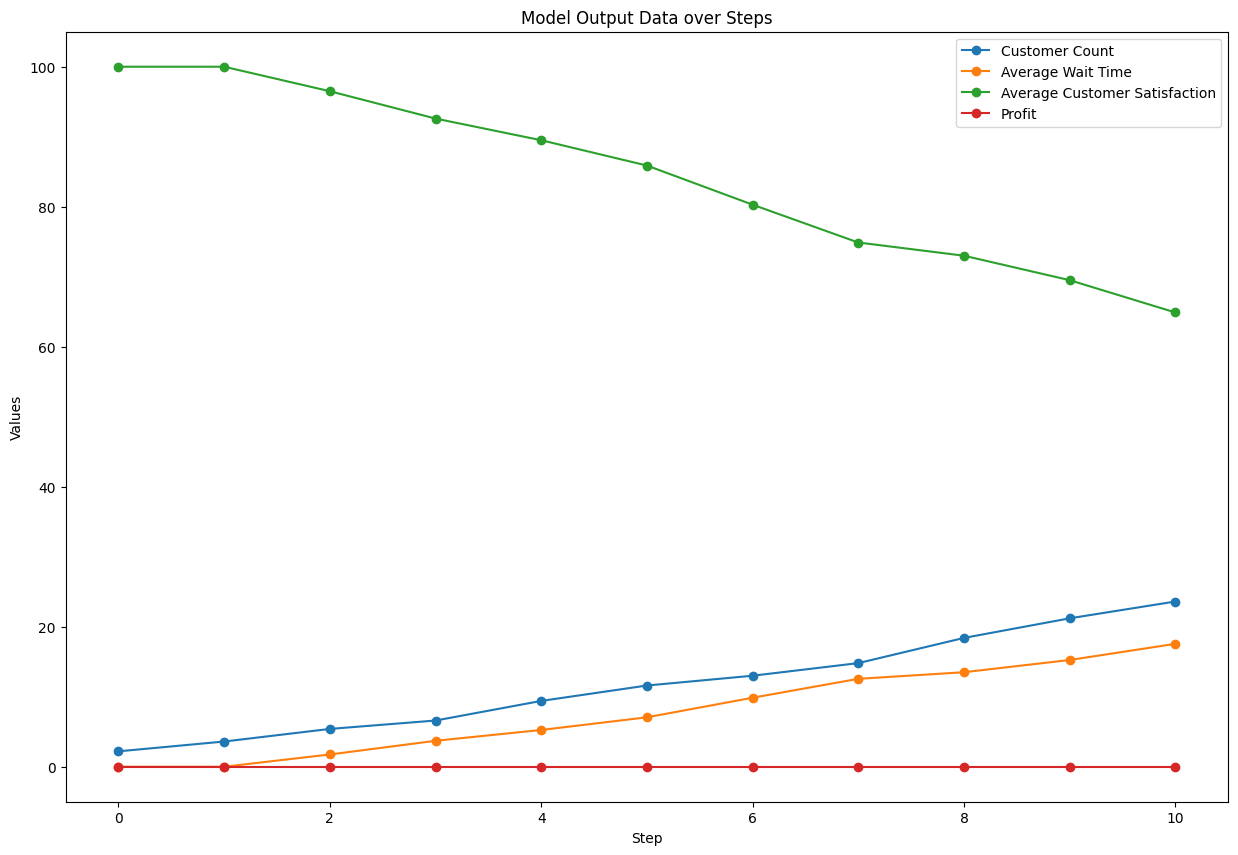

None


None


None


None


None


None


None


In [4]:
from mesa_restaurant_agents.visualization import *

df_mean_step = display_mean_step_results(results)
df_first_run_customer = display_first_run_step_results_customer(results)
df_first_run_waiter = display_first_run_step_results_waiter(results)

In [5]:
df_mean_step

,Step,mean_customer_count,mean_waiting_time,mean_customer_satisfaction,mean_profit
0,0,2.2,0.000000,100.000000,0.0
1,1,3.6,0.000000,100.000000,0.0
2,2,5.4,1.750000,96.500000,0.0
3,3,6.6,3.702778,92.594444,0.0
4,4,9.4,5.250466,89.499068,0.0
5,5,11.6,7.058730,85.882540,0.0
6,6,13.0,9.854237,80.291527,0.0
7,7,14.8,12.556220,74.887560,0.0
8,8,18.4,13.499873,73.000253,0.0
9,9,21.2,15.245128,69.509744,0.0


In [6]:
df_first_run_customer.sort_values(['customer_nr', 'step'])

,customer_nr,waiting_time,order_status,satisfaction,step
0,4,0.0,1,100.0,0
1,4,0.0,1,100.0,1
2,4,5.0,1,90.0,2
4,4,10.0,1,80.0,3
7,4,15.0,1,70.0,4
...,...,...,...,...,...
69,15,5.0,1,90.0,10
57,16,0.0,1,100.0,9
70,16,0.0,1,100.0,10
71,17,0.0,1,100.0,10


In [7]:
df_first_run_waiter.sort_values(['waiter_nr', 'step'])

,waiter_nr,current_orders,tips,avg_rating,served_customers,step
0,1,{},0,0,0,0
2,1,{},0,0,0,1
4,1,{},0,0,0,2
6,1,{},0,0,0,3
8,1,{},0,0,0,4
10,1,{},0,0,0,5
12,1,{},0,0,0,6
14,1,{},0,0,0,7
16,1,{},0,0,0,8
18,1,{},0,0,0,9
